<a href="https://colab.research.google.com/github/ankitc21/finance_causal_rl/blob/main/notebooks/03_lending_club_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
BASE_DIR = "/content/drive/MyDrive/finance_causal_rl"
LC_DIR = os.path.join(BASE_DIR, "data/raw/lending_club")

lc_file = os.path.join(LC_DIR, "accepted_2007_to_2018Q4.csv.gz")

df = pd.read_csv(lc_file, compression="gzip", low_memory=False)

print("Shape:", df.shape)
df.head()

Shape: (2260701, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
cols_needed = [
    "loan_amnt",
    "term",
    "int_rate",
    "grade",
    "emp_length",
    "annual_inc",
    "issue_d",
    "loan_status",
    "purpose",
    "dti",
    "fico_range_low",
    "fico_range_high"
]

df = df[cols_needed]
print("Reduced shape:", df.shape)

Reduced shape: (2260701, 12)


In [5]:
df['loan_status'].value_counts()

,count
loan_status,
Fully Paid,1076751
Current,878317
Charged Off,268559
Late (31-120 days),21467
In Grace Period,8436
Late (16-30 days),4349
Does not meet the credit policy. Status:Fully Paid,1988
Does not meet the credit policy. Status:Charged Off,761
Default,40


#only completed loans

In [6]:
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
df['default'] = (df['loan_status'] == 'Charged Off').astype(int)

print("After filtering:", df.shape)
print("Default rate:", round(df['default'].mean() * 100, 2), "%")

After filtering: (1345310, 13)
Default rate: 19.96 %


#Time Structure

In [7]:
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['year'] = df['issue_d'].dt.year

/tmp/ipython-input-1119759787.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['issue_d'] = pd.to_datetime(df['issue_d'])


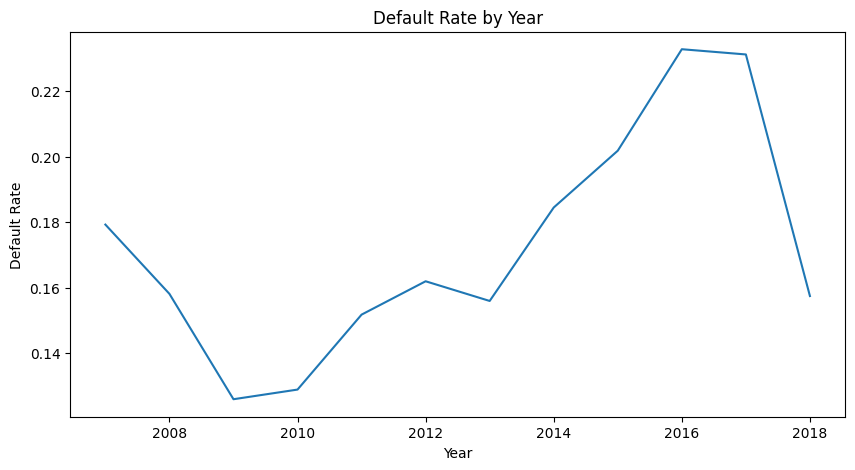

,default
year,
2007,0.179283
2008,0.158131
2009,0.125954
2010,0.128901
2011,0.151789
2012,0.161973
2013,0.155960
2014,0.184494
2015,0.201848


In [8]:
yearly_default = df.groupby('year')['default'].mean()

plt.figure(figsize=(10,5))
plt.plot(yearly_default.index, yearly_default.values)
plt.title("Default Rate by Year")
plt.xlabel("Year")
plt.ylabel("Default Rate")
plt.show()

yearly_default

# Create FICO Score


In [10]:
df['fico_score'] = (df['fico_range_low'] + df['fico_range_high']) / 2

#Default Rate by FICO Bucket

/tmp/ipython-input-644021158.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fico_default = df.groupby('fico_bucket')['default'].mean()


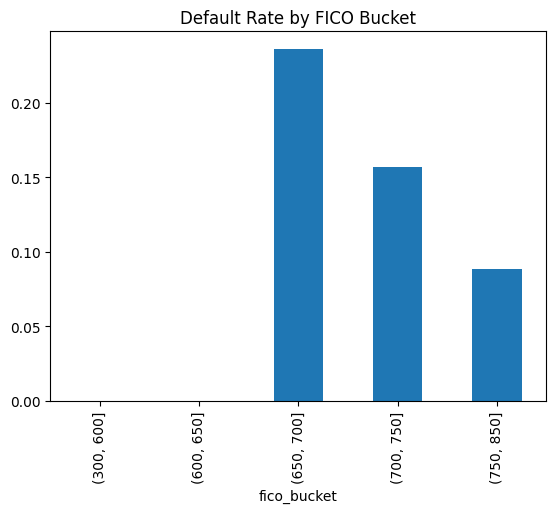

,default
fico_bucket,
"(300, 600]",NaN
"(600, 650]",0.000000
"(650, 700]",0.235908
"(700, 750]",0.156622
"(750, 850]",0.088855


In [12]:
df['fico_bucket'] = pd.cut(df['fico_score'],
                           bins=[300,600,650,700,750,850])

fico_default = df.groupby('fico_bucket')['default'].mean()

fico_default.plot(kind='bar')
plt.title("Default Rate by FICO Bucket")
plt.show()

fico_default

#From the plot:

650–700 → ~23–24% default

700–750 → ~15–16%

750–850 → ~9%

Monotonic decline.
Lower credit quality → higher default.


In [15]:
df['fico_bucket'].value_counts()

,count
fico_bucket,
"(650, 700]",820804
"(700, 750]",417903
"(750, 850]",106601
"(600, 650]",2
"(300, 600]",0


#Default Rate by DTI Bucket

/tmp/ipython-input-953339235.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dti_default = df.groupby('dti_bucket')['default'].mean()


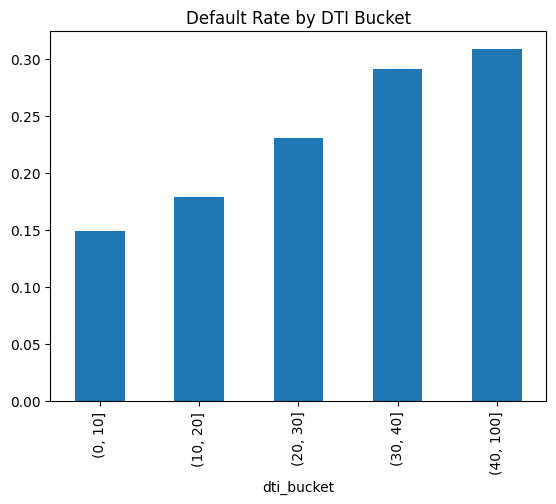

,default
dti_bucket,
"(0, 10]",0.148656
"(10, 20]",0.178443
"(20, 30]",0.230480
"(30, 40]",0.290974
"(40, 100]",0.308680


In [13]:
df['dti_bucket'] = pd.cut(df['dti'], bins=[0,10,20,30,40,100])

dti_default = df.groupby('dti_bucket')['default'].mean()

dti_default.plot(kind='bar')
plt.title("Default Rate by DTI Bucket")
plt.show()

dti_default

#Beautiful monotonic increase:

0–10 → ~15%

10–20 → ~18%

20–30 → ~23%

30–40 → ~29%

40–100 → ~31%

That is textbook credit risk.

Higher debt burden → higher default.

This is exactly the structure we need for capital modeling.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df[['fico_score','dti','annual_inc','loan_amnt']].fillna(0)
y = df['default']

model = LogisticRegression(max_iter=1000)
model.fit(X, y)

for feature, coef in zip(X.columns, model.coef_[0]):
    print(feature, ":", coef)

fico_score : -0.01274085290363054
dti : 0.01661698767043349
annual_inc : -5.168501656032289e-06
loan_amnt : 3.4843396029880634e-05


#Interpretation:

FICO negative → higher FICO reduces default ✔

DTI positive → higher DTI increases default ✔

Income negative → higher income reduces default ✔

Loan amount positive → larger exposure slightly riskier ✔

Signs are economically correct.

That means:

Your dataset is structurally sound.

This is huge.

#Default probability depends on:

PDᵢ = f(FICO, DTI, Income, LoanAmount)

This becomes the micro-PD engine.

Later, macro variables will shift PD upward or downward.

That’s your causal-RL bridge.

In [16]:
df.groupby('year').size()

,0
year,
2007,251
2008,1562
2009,4716
2010,11536
2011,21721
2012,53367
2013,134804
2014,223102
2015,375545


#Why 2008–2009 Didn’t Spike

Because:

• In 2007–2009, Lending Club was tiny
• Only strongest borrowers likely approved
• Sample size too small for stable crisis inference

251 loans in 2007 is statistically meaningless for macro inference.

Your default plot is dominated by:

2013–2017 period (where 80% of data lives)

That’s not wrong. That’s structure.

# Decision Point (Important)

For capital modeling, you should restrict to:

2012–2017

Why?

• Volume is large
• Underwriting is more mature
• Portfolio composition more stable
• Statistical estimates more reliable

Otherwise early years introduce noise.

#Cleaning the dataset for portfolio construction

In [17]:
df = df[df['year'] >= 2012]
print(df.shape)

(1305524, 17)


#EAD (Exposure at Default) → loan_amnt
#PD → empirical default rate conditional on risk bucket
#LGD → assume fixed (starting with 60%)

In [19]:
portfolio_df = df[['loan_amnt', 'fico_score', 'dti', 'annual_inc', 'default']].copy()
portfolio_df.head()

,loan_amnt,fico_score,dti,annual_inc,default
0,3600.0,677.0,5.91,55000.0,0
1,24700.0,717.0,16.06,65000.0,0
2,20000.0,697.0,10.78,63000.0,0
4,10400.0,697.0,25.37,104433.0,0
5,11950.0,692.0,10.20,34000.0,0


#Monte Carlo capital model requires:

For each loan i:

Loss_i = Default_i × LGD × EAD_i

Where Default_i ~ Bernoulli(PD_i)

Right now your empirical PD_i is just observed default frequency.

Later we refine PD_i using logistic model.

#Crude Monte Carlo Economic Capital

We start simple:

Assume:

• Independent defaults

• PD = overall empirical default rate

• LGD = 60% (constant)

• Portfolio = random 1000 loans

In [21]:
import numpy as np

np.random.seed(42)

# Sample 1000 loans randomly
portfolio_sample = portfolio_df.sample(n=1000, random_state=42).reset_index(drop=True)

portfolio_sample.head()

,loan_amnt,fico_score,dti,annual_inc,default
0,30000.0,732.0,8.75,120000.0,0
1,19050.0,707.0,26.38,175000.0,1
2,24000.0,687.0,7.60,95000.0,0
3,18000.0,667.0,12.67,87500.0,0
4,5600.0,672.0,25.88,25000.0,1


In [22]:
LGD = 0.60

# empirical PD
PD = portfolio_sample['default'].mean()

print("Empirical PD:", PD)

Empirical PD: 0.185


In [23]:
n_sim = 10000
losses = []

EAD = portfolio_sample['loan_amnt'].values

for _ in range(n_sim):

    # simulate defaults
    defaults_sim = np.random.binomial(1, PD, size=1000)

    # compute loss
    loss = np.sum(defaults_sim * LGD * EAD)

    losses.append(loss)

losses = np.array(losses)

In [25]:
VaR_99 = np.percentile(losses, 99)
VaR_999 = np.percentile(losses, 99.9)

print("VaR 99%:", VaR_99)
print("VaR 99.9%:", VaR_999)

VaR 99%: 1908240.15
VaR 99.9%: 1992616.9200000004


In [26]:
VaR_99_list = []

for _ in range(100):

    losses = []

    for _ in range(n_sim):
        defaults_sim = np.random.binomial(1, PD, size=1000)
        loss = np.sum(defaults_sim * LGD * EAD)
        losses.append(loss)

    VaR_99_list.append(np.percentile(losses, 99))

print("Mean VaR 99:", np.mean(VaR_99_list))
print("Std VaR 99:", np.std(VaR_99_list))

Mean VaR 99: 1908410.8185000003
Std VaR 99: 5071.088573475404


# 1️⃣ Empirical PD

You got:

PD = 0.185
→ 18.5%

That matches your EDA (~15–23% range depending on year).
So PD is consistent. Good.

# 2️⃣ VaR Results

You obtained:

VaR 99% ≈ 1,908,240
VaR 99.9% ≈ 1,992,616

For a 1000-loan portfolio.

First instinct: does this magnitude make sense?

Let’s sanity-check quickly in our heads.

Expected loss (EL) roughly equals:

EL = PD × LGD × Total Exposure

Let’s approximate:

If average loan size ≈ 15,000 (rough estimate from LC data)

Total exposure ≈ 1000 × 15,000 = 15,000,000

EL ≈ 0.185 × 0.60 × 15,000,000
EL ≈ 0.111 × 15,000,000
EL ≈ 1,665,000

Your 99% VaR ≈ 1.9M

# That’s slightly above expected loss, which is reasonable for an independent binomial model.

So magnitude makes sense.

Not absurd.
Not exploding.
Not tiny.

That’s exactly what we want in a baseline.

# 3️⃣ Stability of VaR

Mean VaR 99 ≈ 1,908,410
Std VaR 99 ≈ 5,071

# This is very small relative to the mean.

Coefficient of variation:

5071 / 1,908,410 ≈ 0.26%

That means:

Monte Carlo sampling error is tiny.

# Your simulation is stable.

# This is a good baseline.

# 4️⃣ Important Insight

Notice something subtle.

99% VaR ≈ 1.9M
99.9% VaR ≈ 1.99M

Difference ≈ 84,000

# That is surprisingly small.

Why?

Because independent defaults produce thin tails.

There is no correlation.

No systemic shock.

No contagion.

# That is the key weakness of this model.

And that weakness is exactly what your future causal/macro integration will address.

Right now you have built:

A Gaussian-like independent loss model.

It underestimates tail risk.

In [27]:
expected_loss = PD * LGD * np.sum(EAD)
print("Expected Loss:", expected_loss)

Expected Loss: 1612238.925


#You have:

Expected Loss (EL) ≈ 1,612,239
VaR 99% ≈ 1,908,240

So:

Economic Capital (99%)
= VaR − EL
≈ 1,908,240 − 1,612,239
≈ 296,001

That ~296k is your unexpected loss buffer.

Now let’s think about what that means.

Interpretation

Total exposure roughly ~15M (approx from earlier logic).

EL ≈ 1.61M → this is average credit loss.

VaR 99 ≈ 1.91M → extreme but plausible loss.

Capital buffer ≈ 296k → cushion for unexpected variation.

That is about:

296k / 15M ≈ 2% of exposure

Which is small.

And that makes sense because:

• Defaults assumed independent
• No macro shocks
• No correlation
• No contagion

Independent binomial portfolios have thin tails.

You’ve just mathematically confirmed why independent default models underestimate tail risk.

This is a beautiful teaching moment.

Now the Real Insight

Look at this:

# EL = 1.61M
VaR 99 = 1.91M

# Difference = only 18% above EL.

In real banking portfolios:

# Tail losses are much fatter.

Correlation explodes tail risk.

That’s why Basel models include systemic factors (Vasicek one-factor model).

Right now your model says:

“Defaults happen independently. The world is calm.”

But the real world is not calm.
